In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lars, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
sns.set_context('talk',font_scale=1)

In [2]:
### SET UP INITIAL FEATURES ###

# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
Xtrain = Xtrain.reset_index(drop = True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Xtrain.loc[index, 'Visit'] = '1 Month'

# summarize features, separating by subject-visit and pair with MDS scores and Baseline MDS scores
features = pd.DataFrame()
for s in Xtrain['Subject'].unique():
    strain = Xtrain[Xtrain['Subject'] == s]
    for v in strain['Visit'].unique():
        vtrain = strain[strain['Visit'] == v]
        
        # get MDS and baseline MDS scores
        mds = float('Nan')
        baseline_mds = float('Nan')
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        # skip rows without valid MDS and baseline MDS scores
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            continue
        # create new features dataframe
        vtrain = vtrain.iloc[:, 5:-2]
        cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
        vals = [s, mds, v, baseline_mds]
        for c in vtrain.columns.values.tolist():
            cols.append(c + " mean")
            cols.append(c + " var")
            vals.append(vtrain[c].mean())
            vals.append(vtrain[c].var())
        df = pd.DataFrame(data = [vals], columns = cols)
        features = features.append(df, ignore_index = True)
# renumber visits
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
features     

,Subject,MDS score,Visit,baseline MDS,RMSX mean,RMSX var,RMSY mean,RMSY var,RMSZ mean,RMSZ var,...,PSD_std mean,PSD_std var,PSD_skew mean,PSD_skew var,PSD_kur mean,PSD_kur var,jerk_mean mean,jerk_mean var,jerk_std mean,jerk_std var
0,1016,19,0,20,0.004069,0.000009,0.006068,0.000050,0.004941,0.000036,...,0.001677,9.506376e-06,3.579956,1.462709,14.899901,92.664206,0.000091,4.985616e-07,0.053216,0.001760
1,1016,21,1,20,0.004030,0.000008,0.005652,0.000020,0.005489,0.000045,...,0.001495,6.207789e-06,3.532259,1.520124,14.551906,90.698890,0.000030,2.180829e-07,0.050629,0.001093
2,1016,32,2,20,0.004209,0.000010,0.005931,0.000026,0.005829,0.000057,...,0.001434,5.940771e-06,3.504365,1.557862,14.455093,92.683970,0.000047,2.655185e-07,0.054084,0.001657
3,1018,18,0,13,0.004221,0.000015,0.005597,0.000030,0.004696,0.000027,...,0.000960,2.036911e-06,3.393138,1.491039,13.761422,87.966827,-0.000007,2.571958e-07,0.050164,0.001500
4,1018,13,1,13,0.005074,0.000023,0.005855,0.000031,0.005253,0.000038,...,0.001150,2.396294e-06,3.486258,1.650707,14.442100,91.659130,0.000015,2.685295e-07,0.049711,0.001100
5,1018,14,2,13,0.005674,0.000029,0.007112,0.000040,0.005473,0.000040,...,0.001626,3.712757e-06,3.535584,1.763819,14.701650,94.373516,0.000025,3.729535e-07,0.059454,0.001779
6,1019,36,0,18,0.004645,0.000015,0.005396,0.000015,0.004298,0.000008,...,0.001134,2.796317e-06,3.552093,1.542282,14.634744,100.838031,-0.000067,1.990697e-07,0.058229,0.001620
7,1019,14,1,18,0.005892,0.000024,0.007727,0.000042,0.006619,0.000068,...,0.002283,1.452662e-05,3.360709,1.561567,13.149991,91.126949,-0.000004,4.998648e-07,0.072822,0.002568
8,1019,10,2,18,0.004328,0.000011,0.005961,0.000018,0.004678,0.000019,...,0.000942,1.040814e-06,3.499910,1.327562,14.137388,80.840255,-0.000020,2.224008e-07,0.055788,0.001234
9,1023,36,0,28,0.006958,0.000012,0.009098,0.000053,0.007421,0.000045,...,0.003037,2.972705e-05,3.234112,1.428213,12.449889,80.659598,-0.000024,7.276790e-07,0.093025,0.003586


In [3]:
### CALCULATE THE FIRST STACK ###

# setup needed variables
a = []; b = []; v = []; subjs = []
pred_RFR = []; pred_NN = []; pred_LN = []; pred_LARS = []; pred_KNR = []

# use a leave one subject out approach to train the models
for s in features['Subject'].unique():

    # create regressors
    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    # select training set
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] != 0)] # use data from Visits 1 & 2 only (on medication)
    ytrain = Xtrain['MDS score'].values.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    
    # scale the training set
    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    # train the regressors
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    # set up the test set
    Xtest = features[(features['Subject'] == s) & (features['Visit'] != 0)] # use data from Visits 1 & 2 only (on medication)
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)
    Xtest = Xtest.iloc[:, 4:].values
    
    # make predictions and store in stacked_predictions dataframe
    if (len(Xtest) != 0):
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LARS', value = pred_LARS)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.081644,0.307243,0.640108,-0.117422,0.296862,-0.506752,0.410357
actual mds,-0.081644,1.000000,0.578878,-0.226663,0.100463,0.099100,0.030511,-0.555554
baseline mds,0.307243,0.578878,1.000000,0.182907,0.071021,0.195203,-0.351007,-0.287543
pred RFR,0.640108,-0.226663,0.182907,1.000000,0.281100,0.574562,-0.624400,0.704499
pred NN,-0.117422,0.100463,0.071021,0.281100,1.000000,0.453268,0.044070,0.405534
pred LN,0.296862,0.099100,0.195203,0.574562,0.453268,1.000000,-0.442372,0.504513
pred LARS,-0.506752,0.030511,-0.351007,-0.624400,0.044070,-0.442372,1.000000,-0.324846
pred KNR,0.410357,-0.555554,-0.287543,0.704499,0.405534,0.504513,-0.324846,1.000000


In [4]:
### CALCULATE FINAL PREDICTIONS FROM THE FIRST STACK ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []; 
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out approach to train the data
for s in stacked_predictions['subj'].unique():
    # select train and test sets
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    # scale train and test sets
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    #train the regressors
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make final predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.081644,-0.090741,0.065092,-0.114977,-0.114977,-0.056704
actual mds,-0.081644,1.000000,0.669702,0.448995,0.575053,0.575053,0.603128
pred RFR,-0.090741,0.669702,1.000000,0.720202,0.649900,0.649900,0.869921
pred NN,0.065092,0.448995,0.720202,1.000000,0.718968,0.718968,0.656956
pred LN,-0.114977,0.575053,0.649900,0.718968,1.000000,1.000000,0.699833
pred LARS,-0.114977,0.575053,0.649900,0.718968,1.000000,1.000000,0.699833
pred KNR,-0.056704,0.603128,0.869921,0.656956,0.699833,0.699833,1.000000


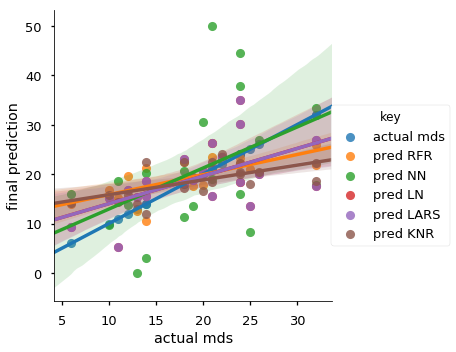

In [5]:
### DISPLAY FINAL PREDICTIONS (from first stack only) ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[1:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1)

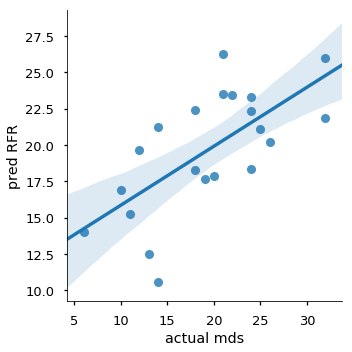

In [6]:
### 1 stack followed by RFR ###
sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1)

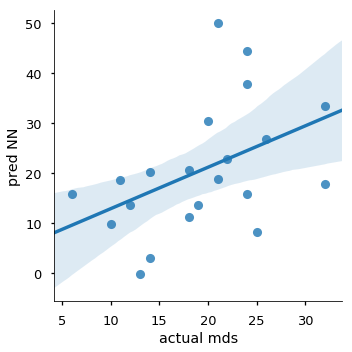

In [7]:
### 1 stack followed by NN ###
sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1)

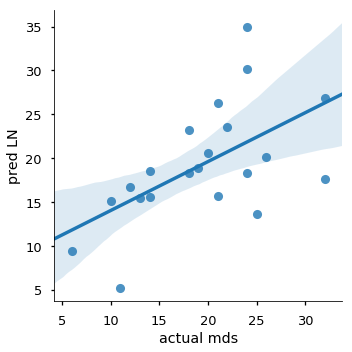

In [8]:
### 1 stack followed by LN ###
sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1)

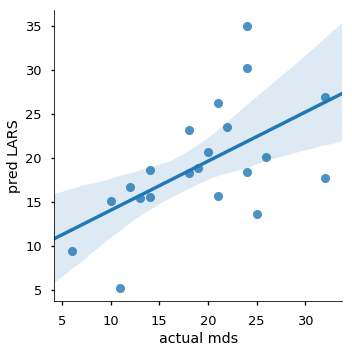

In [9]:
### 1 stack followed by LARS ###
sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1)

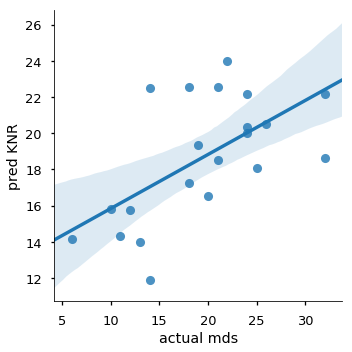

In [10]:
### 1 stack followed by KNR ###
sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1)

In [11]:
### CALCULATE SECOND STACK FROM FIRST STACK (without using baseline) ###

# setup needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out approach to train models
for s in stacked_predictions['subj'].unique():
    # set up test and train sets
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    # scale test amd train sets
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train models
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.081644,0.307243,-0.102033,-0.401662,-0.307848,-0.307848,-0.306071
actual mds,-0.081644,1.000000,0.578878,0.669056,0.329873,0.602009,0.602009,0.513316
baseline mds,0.307243,0.578878,1.000000,0.416433,-0.004865,0.455340,0.455340,0.134312
pred RFR,-0.102033,0.669056,0.416433,1.000000,0.560854,0.684124,0.684124,0.757826
pred NN,-0.401662,0.329873,-0.004865,0.560854,1.000000,0.701260,0.701260,0.600253
pred LN,-0.307848,0.602009,0.455340,0.684124,0.701260,1.000000,1.000000,0.583465
pred LARS,-0.307848,0.602009,0.455340,0.684124,0.701260,1.000000,1.000000,0.583465
pred KNR,-0.306071,0.513316,0.134312,0.757826,0.600253,0.583465,0.583465,1.000000


,subj,actual mds,final prediction
subj,1.000000,-0.081644,0.005666
actual mds,-0.081644,1.000000,0.623021
final prediction,0.005666,0.623021,1.000000


num data points: 21
correlation coefficient: 0.6230211254783313
RMSE: 5.326308468795429
Cohen Kappa Score: 0.08915662650602396


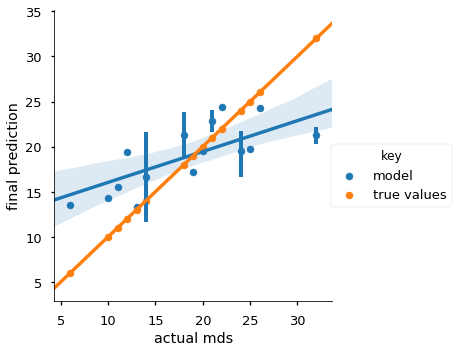

,subj,actual mds,final prediction
subj,1.000000,-0.081644,0.080267
actual mds,-0.081644,1.000000,0.714014
final prediction,0.080267,0.714014,1.000000


num data points: 21
correlation coefficient: 0.7140141098245908
RMSE: 5.830226212164304
Cohen Kappa Score: 0.10849056603773577


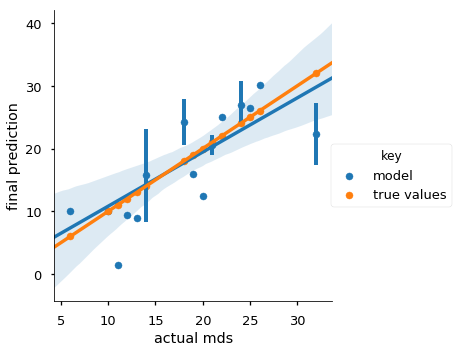

,subj,actual mds,final prediction
subj,1.000000,-0.081644,-0.176624
actual mds,-0.081644,1.000000,0.550824
final prediction,-0.176624,0.550824,1.000000


num data points: 21
correlation coefficient: 0.5508237084929056
RMSE: 5.973756849870346
Cohen Kappa Score: 0.002375296912114022


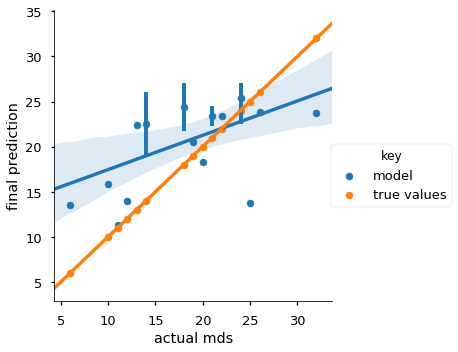

,subj,actual mds,final prediction
subj,1.000000,-0.081644,0.210425
actual mds,-0.081644,1.000000,0.571057
final prediction,0.210425,0.571057,1.000000


num data points: 21
correlation coefficient: 0.571057127719719
RMSE: 6.0638406130316325
Cohen Kappa Score: -0.03764705882352937


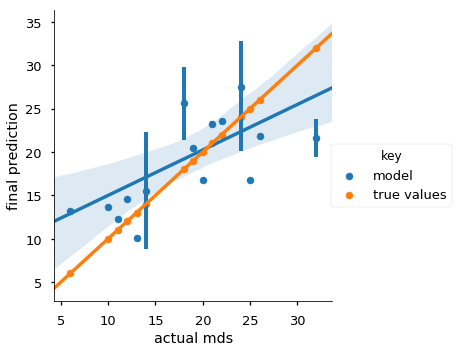

,subj,actual mds,final prediction
subj,1.000000,-0.081644,0.165459
actual mds,-0.081644,1.000000,0.687471
final prediction,0.165459,0.687471,1.000000


num data points: 21
correlation coefficient: 0.6874709879651185
RMSE: 4.959126690335034
Cohen Kappa Score: 0.0


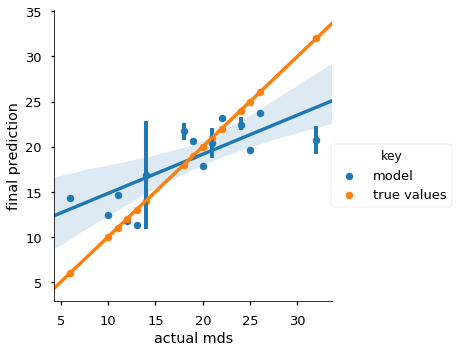

In [12]:
### CALCULATE FINAL PREDICTIONS FROM SECOND STACK ###

# make regressors
clfs = [RandomForestRegressor(n_estimators=50, random_state = 2), MLPRegressor(max_iter = 10000, random_state = 2), 
        LinearRegression(), Lars(eps = 2.220446049250313e-7), KNeighborsRegressor(weights = 'distance')]

# display final results for each regressor
for clf_final in clfs:

    # setup needed variables
    actual_mds = []; predictions_final = []; subjs3 = []
    
    # use a leave one subject out approach to train models
    for s in second_stack_predictions['subj'].unique():
        # setup train and test data
        second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
        second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
        second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
        second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
        second_stack_train = second_stack_train.iloc[:, 2:].values
        second_stack_test = second_stack_test.iloc[:, 2:].values
    
        # scale train and test data
        scaler = StandardScaler() 
        scaler.fit(second_stack_train)  
        second_stack_std = scaler.transform(second_stack_train)
        second_stack_test_std = scaler.transform(second_stack_test)
    
        # train the model
        clf_final.fit(second_stack_std, second_stack_ytrain)
    
        # make predictions and store in predictions DataFrame()
        if (len(second_stack_test) != 0):
            actual_mds += list(second_stack_ytest)
            predictions_final += list(clf_final.predict(second_stack_test_std))
            subjs3 += [s for elem in list(second_stack_ytest)]
    predictions = pd.DataFrame()
    predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
    predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
    predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
    display(predictions.corr())
    
    # display results
    predictions['key'] = 'model'
    actual_for_comp = pd.DataFrame()
    actual_for_comp['subj'] = predictions['subj']
    actual_for_comp['actual mds'] = predictions['actual mds']
    actual_for_comp['final prediction'] = predictions['actual mds']
    actual_for_comp['key'] = 'true values'

    print("num data points: " + len(predictions.index.values).__str__())
    print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
    print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 
    print('Cohen Kappa Score: ' + cohen_kappa_score([int(p) for p in predictions['final prediction'].values], [int(p) for p in predictions['actual mds']]).__str__()) 
    
    df_display = predictions.append(actual_for_comp, ignore_index = True)
    sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator=np.mean)
    plt.show()